# News classification with topic models in gensim
News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

Our aim in this tutorial is to come up with some topic model which can come up with topics that can easily be interpreted by us. Such a topic model can be used to discover hidden structure in the corpus and can also be used to determine the membership of a news article into one of the topics.

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

Accompanying slides can be found [here](https://speakerdeck.com/dsquareindia/pycon-delhi-lightening).

### Requirements
In this tutorial we look at how different topic models can be easily created using [gensim](https://radimrehurek.com/gensim/).
Following are the dependencies for this tutorial:
    - Gensim Version >=0.13.1 would be preferred since we will be using topic coherence metrics extensively here.
    - matplotlib
    - nltk.stopwords and nltk.wordnet
    - pyLDAVis

In [1]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

import nltk

from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
from pprint import pprint

%matplotlib inline

import load_lee_background_corpus as load_texts

Analysing our corpus.
    - The first document talks about a bushfire that had occured in New South Wales.
    - The second talks about conflict between India and Pakistan in Kashmir.
    - The third talks about road accidents in the New South Wales area.
    - The fourth one talks about Argentina's economic and political crisis during that time.
    - The last one talks about the use of drugs by midwives in a Sydney hospital.
Our final topic model should be giving us keywords which we can easily interpret and make a small summary out of. Without this the topic model cannot be of much practical use.

In [2]:
lee_train_file = load_texts.get_lee_train_file()
with open(lee_train_file) as f:
    for n, l in enumerate(f):
        if n < 6:
            print([l])

/Users/home/Desenvolvimento/anaconda3/lib/python3.6/site-packages/gensim/test/test_data
['Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have bee

### Preprocessing our data. Remember: Garbage In Garbage Out
                                        "NLP is 80% preprocessing."
                                                                -Lev Konstantinovskiy
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
1. Stopword removal using NLTK's english stopwords dataset.
2. Bigram collocation detection (frequently co-occuring tokens) using gensim's [Phrases](https://radimrehurek.com/gensim/models/phrases.html). This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
3. Lemmatization (using gensim's [`lemmatize`](https://radimrehurek.com/gensim/utils.html#gensim.utils.lemmatize)) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [3]:
texts = load_texts.get_raw_texts()
print(texts[5])

/Users/home/Desenvolvimento/anaconda3/lib/python3.6/site-packages/gensim/test/test_data
The Federal Government says it should be safe for Afghani asylum seekers in Australia to return home when the environment becomes secure. The Government has suspended their applications while the interim government is established in Kabul. The Foreign Affairs Minister Alexander Downer has refused to say for how long the claims process has been put on hold. But he says the major threat to most people seeking asylum is no longer there. "Many Afghans who have tried to get into Australia or for that matter into Britain and other countries in north-west Europe have claimed that they are fleeing the Taliban," he said. "Well, the Taliban is no longer in power in Afghanistan, the Taliban is finished." Meanwhile, there has been a mass airlift of detainees from Christmas Island to the Pacific Island of Nauru. In total, more than 300 people have been flown from the island in two operations using chartered airc

In [4]:
texts = load_texts.process_file(lee_train_file, keep_all=True)
print(texts[5])

2017-11-22 01:39:32,884 : INFO : collecting all words and their counts
2017-11-22 01:39:32,887 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-11-22 01:39:32,977 : INFO : collected 39691 word types from a corpus of 48449 words (unigram + bigrams) and 300 sentences
2017-11-22 01:39:32,979 : INFO : using 39691 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


['federal_government', 'say', 'safe', 'afghani', 'asylum_seekers', 'australia', 'return', 'home', 'environment', 'becomes', 'secure', 'government', 'suspended', 'application', 'interim_government', 'established', 'kabul', 'foreign_affairs', 'minister_alexander', 'downer', 'refused', 'say', 'long', 'claim', 'process', 'has_been', 'put', 'hold', 'say', 'major', 'threat', 'people', 'seeking', 'asylum', 'longer', 'many', 'afghan', 'tried', 'get', 'australia', 'matter', 'britain', 'country', 'north', 'west', 'europe', 'claimed', 'they_are', 'fleeing', 'taliban', 'said', 'well', 'taliban', 'longer', 'power', 'afghanistan', 'taliban', 'finished', 'meanwhile', 'has_been', 'mass', 'airlift', 'detainee', 'christmas', 'island', 'pacific', 'island', 'nauru', 'total', 'more_than', 'people', 'have_been', 'flown', 'island', 'two', 'operation', 'using', 'chartered', 'aircraft', 'second', 'airlift', 'today', 'delivered', 'asylum_seekers', 'nauru', 'await', 'processing', 'claim', 'temporary', 'visa', 'd

In [5]:
train_texts = load_texts.process_file(lee_train_file, keep_all=False)
print(train_texts[5])

2017-11-22 01:40:24,435 : INFO : collecting all words and their counts
2017-11-22 01:40:24,436 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-11-22 01:40:24,479 : INFO : collected 20429 word types from a corpus of 19878 words (unigram + bigrams) and 300 sentences
2017-11-22 01:40:24,481 : INFO : using 20429 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


['federal_government', 'afghani', 'asylum_seekers', 'australia', 'home', 'environment', 'secure', 'government', 'application', 'government', 'kabul', 'foreign_affairs', 'minister_alexander', 'downer', 'claim', 'process', 'hold', 'threat', 'people', 'asylum', 'afghan', 'australia', 'matter', 'britain', 'country', 'europe', 'taliban', 'taliban', 'power', 'afghanistan', 'taliban', 'mass', 'airlift', 'detainee', 'christmas', 'island', 'pacific', 'island', 'nauru', 'people', 'island', 'operation', 'aircraft', 'airlift', 'today', 'asylum_seekers', 'nauru', 'processing', 'claim', 'visa', 'department', 'immigration', 'detainee', 'christmas', 'island', 'spokesman', 'decision', 'future']


Finalising our dictionary and corpus

In [6]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

2017-11-22 01:10:35,725 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-22 01:10:35,764 : INFO : built Dictionary(4431 unique tokens: ['hundreds', 'people', 'homes', 'southern', 'highlands']...) from 300 documents (total 18861 corpus positions)


### Topic modeling using [LDA](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei. Let's choose 10 topics to initialize this.

In [7]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

2017-11-22 01:10:35,797 : INFO : using symmetric alpha at 0.1
2017-11-22 01:10:35,802 : INFO : using symmetric eta at 0.00022568269013766644
2017-11-22 01:10:35,807 : INFO : using serial LDA version on this node
2017-11-22 01:10:36,287 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 01:10:36,289 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 01:10:36,919 : DEBUG : bound: at document #0
2017-11-22 01:10:38,797 : INFO : -11.676 per-word bound, 3272.3 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-22 01:10:38,799 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-22 01:10:38,801 : DEBUG : performing inference on a chunk of 300 documen

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. pyLDAvis is based on [this](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [8]:
import pyLDAvis.gensim

In [9]:
pyLDAvis.enable_notebook()

In [10]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

2017-11-22 01:10:40,329 : DEBUG : performing inference on a chunk of 300 documents
2017-11-22 01:10:40,849 : DEBUG : 261/300 documents converged within 50 iterations
/Users/home/Desenvolvimento/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      15.976778        1       1  0.074143  0.045919
4      14.748015        1       2  0.010210 -0.004822
2      11.522496        1       3 -0.010270 -0.041577
8      11.322713        1       4 -0.005559  0.009409
3      10.191580        1       5  0.006633  0.040796
1       9.489028        1       6  0.029626 -0.061053
9       7.750577        1       7 -0.076655  0.015267
7       7.280897        1       8 -0.010690 -0.094129
6       6.439583        1       9  0.065674  0.036751
0       5.278335        1      10 -0.083113  0.053439, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
220   Default   80.000000     afghanistan   80.000000  30.0000  30.0000
596   Default   42.000000            test   42.000000  29.0000  29.0000
165   Default  107.000000      government  107.000000  28.0000  28.0000
845   Default   69.000000          arafat   69.000000  27.0000  27.0000
131   Default  122.000000       australia  122.000000  26.0000  26.0000
1687  Default   28.000000          qantas   28.000000  25.0000  25.0000
987   Default   37.000000           laden   37.000000  24.0000  24.0000
1562  Default   27.000000           hamas   27.000000  23.0000  23.0000
237   Default   29.000000            team   29.000000  22.0000  22.0000
1516  Default   30.000000       tora_bora   30.000000  21.0000  21.0000
152   Default   38.000000           years   38.000000  20.0000  20.0000
90    Default   66.000000          police   66.000000  19.0000  19.0000
135   Default    9.000000       argentina    9.000000  18.0000  18.0000
17    Default   45.000000          sydney   45.000000  17.0000  17.0000
218   Default   45.000000         taliban   45.000000  16.0000  16.0000
1150  Default   21.000000           radio   21.000000  15.0000  15.0000
71    Default   19.000000    firefighters   19.000000  14.0000  14.0000
112   Default   40.000000        pakistan   40.000000  13.0000  13.0000
2584  Default   11.000000           space   11.000000  12.0000  12.0000
147   Default    7.000000            debt    7.000000  11.0000  11.0000
3128  Default    4.000000         farmers    4.000000  10.0000  10.0000
2489  Default   20.000000          sharon   20.000000   9.0000   9.0000
76    Default   54.000000          forces   54.000000   8.0000   8.0000
679   Default   51.000000             man   51.000000   7.0000   7.0000
3075  Default    7.000000         lockett    7.000000   6.0000   6.0000
1659  Default   11.000000      east_timor   11.000000   5.0000   5.0000
2380  Default   24.000000          unions   24.000000   4.0000   4.0000
6     Default   32.000000           wales   32.000000   3.0000   3.0000
615   Default   10.000000          hewitt   10.000000   2.0000   2.0000
912   Default   29.000000          metres   29.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
3059  Topic10    1.043679       defendant    2.208717   2.1919  -6.8605
2692  Topic10    2.946995         islands    8.513147   1.8807  -5.8225
3037  Topic10    2.381911         verdict    6.733753   1.9023  -6.0354
523   Topic10    2.110109    peacekeepers    6.228180   1.8592  -6.1566
2691  Topic10    1.899483         solomon    5.362243   1.9038  -6.2617
2803  Topic10    1.903286           sarah    5.437248   1.8919  -6.2597
3145  Topic10    1.656272           grant    4.438695   1.9558  -6.3987
165   Topic10    8.236043      government  107.704265   0.3707  -4.7948
2157  Topic10    2.379472            july    9.063282   1.6042  -6.0364
20    Topic10    2.230295         highway    8.327552   1.6241  -6.1012
555   Topic10    4.047794          months   31.243263   0.8979  -5.5051
572   Topic10    2.694484            boat   15.005493   1.2244  -5.9121
1842  Topic10    2.545883            bill   13.110947   1.3026  -5.96

### Finding out the optimal number of topics
Topic coherence in essence measures the human interpretability of a topic model. Traditionally [perplexity has been used](http://qpleple.com/perplexity-to-evaluate-topic-models/) to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. Here's a short blog I wrote explaining topic coherence:
[What is topic coherence?](https://rare-technologies.com/what-is-topic-coherence/)

In [11]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

2017-11-22 01:10:41,966 : INFO : using symmetric alpha at 1.0
2017-11-22 01:10:41,970 : INFO : using symmetric eta at 0.00022568269013766644
2017-11-22 01:10:41,974 : INFO : using serial LDA version on this node
2017-11-22 01:10:42,030 : INFO : running online (single-pass) LDA training, 1 topics, 1 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-22 01:10:42,031 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-22 01:10:42,064 : DEBUG : bound: at document #0
2017-11-22 01:10:43,163 : INFO : -8.697 per-word bound, 415.0 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-22 01:10:43,164 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-22 01:10:43,166 : DEBUG : performing inference on a chunk of 300 documents


2017-11-22 01:10:50,335 : INFO : topic #2 (0.333): 0.007*"australia" + 0.006*"people" + 0.006*"afghanistan" + 0.005*"government" + 0.004*"company" + 0.004*"days" + 0.003*"today" + 0.003*"man" + 0.003*"metres" + 0.003*"fire"
2017-11-22 01:10:50,337 : INFO : topic diff=1.219663, rho=1.000000
2017-11-22 01:10:50,340 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=4431, num_topics=3, decay=0.5, chunksize=2000)
2017-11-22 01:10:50,343 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 01:10:50,405 : DEBUG : completed batch 0; 64 documents processed (92 virtual)
2017-11-22 01:10:50,437 : DEBUG : completed batch 0; 64 documents processed (305 virtual)
2017-11-22 01:10:50,438 : DEBUG : completed batch 0; 64 documents processed (258 virtual)
2017-11-22 01:10:50,444 : DEBUG : observed sentinel value; terminating
2017-11-22 01:10:50,451 : DEBUG : finished all batches; 64 documents processed (258

2017-11-22 01:10:58,391 : INFO : topic diff=2.101508, rho=1.000000
2017-11-22 01:10:58,394 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=4431, num_topics=5, decay=0.5, chunksize=2000)
2017-11-22 01:10:58,396 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 01:10:58,474 : DEBUG : completed batch 0; 64 documents processed (92 virtual)
2017-11-22 01:10:58,506 : DEBUG : completed batch 0; 64 documents processed (258 virtual)
2017-11-22 01:10:58,509 : DEBUG : completed batch 0; 64 documents processed (305 virtual)
2017-11-22 01:10:58,514 : DEBUG : observed sentinel value; terminating
2017-11-22 01:10:58,518 : DEBUG : finished all batches; 64 documents processed (305 virtual)
2017-11-22 01:10:58,522 : INFO : serializing accumulator to return to master...
2017-11-22 01:10:58,528 : INFO : accumulator serialized
2017-11-22 01:10:58,533 : DEBUG : completed batch 1; 128 documents processed (

2017-11-22 01:11:07,423 : INFO : topic diff=3.376669, rho=1.000000
2017-11-22 01:11:07,426 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=4431, num_topics=7, decay=0.5, chunksize=2000)
2017-11-22 01:11:07,429 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 01:11:07,512 : DEBUG : completed batch 0; 64 documents processed (92 virtual)
2017-11-22 01:11:07,564 : DEBUG : completed batch 0; 64 documents processed (258 virtual)
2017-11-22 01:11:07,568 : DEBUG : completed batch 0; 64 documents processed (305 virtual)
2017-11-22 01:11:07,575 : DEBUG : observed sentinel value; terminating
2017-11-22 01:11:07,582 : DEBUG : finished all batches; 64 documents processed (305 virtual)
2017-11-22 01:11:07,587 : INFO : serializing accumulator to return to master...
2017-11-22 01:11:07,596 : INFO : accumulator serialized
2017-11-22 01:11:07,594 : DEBUG : completed batch 1; 128 documents processed (

2017-11-22 01:11:16,901 : INFO : topic diff=4.736394, rho=1.000000
2017-11-22 01:11:16,904 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=4431, num_topics=9, decay=0.5, chunksize=2000)
2017-11-22 01:11:16,907 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-11-22 01:11:17,006 : DEBUG : completed batch 0; 64 documents processed (92 virtual)
2017-11-22 01:11:17,040 : DEBUG : completed batch 0; 64 documents processed (258 virtual)
2017-11-22 01:11:17,058 : DEBUG : completed batch 0; 64 documents processed (305 virtual)
2017-11-22 01:11:17,064 : DEBUG : observed sentinel value; terminating
2017-11-22 01:11:17,067 : DEBUG : finished all batches; 64 documents processed (305 virtual)
2017-11-22 01:11:17,072 : INFO : serializing accumulator to return to master...
2017-11-22 01:11:17,083 : INFO : accumulator serialized
2017-11-22 01:11:17,122 : DEBUG : completed batch 1; 128 documents processed (

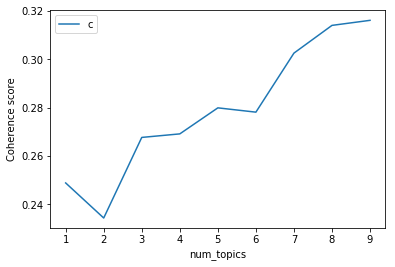

CPU times: user 34 s, sys: 874 ms, total: 34.8 s
Wall time: 36 s


In [12]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)

In [13]:
pyLDAvis.gensim.prepare(lmlist[8], corpus, dictionary)

2017-11-22 01:11:17,989 : DEBUG : performing inference on a chunk of 300 documents
2017-11-22 01:11:18,491 : DEBUG : 260/300 documents converged within 50 iterations
/Users/home/Desenvolvimento/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      14.945762        1       1  0.072089 -0.000847
6      13.780041        1       2  0.024113  0.013608
8      13.349641        1       3  0.025229  0.039164
1      12.806610        1       4  0.004053  0.012297
5      12.138166        1       5  0.046273  0.030303
0      11.446021        1       6 -0.029974 -0.054651
2       8.693269        1       7 -0.008390 -0.073748
7       6.731656        1       8 -0.030598 -0.020529
3       6.108833        1       9 -0.102793  0.054402, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
912   Default   25.000000         metres   25.000000  30.0000  30.0000
295   Default   42.000000          world   42.000000  29.0000  29.0000
255   Default   12.000000          event   12.000000  28.0000  28.0000
511   Default   38.000000         afghan   38.000000  27.0000  27.0000
237   Default   29.000000           team   29.000000  26.0000  26.0000
596   Default   41.000000           test   41.000000  25.0000  25.0000
35    Default   48.000000           fire   48.000000  24.0000  24.0000
628   Default   13.000000    new_zealand   13.000000  23.0000  23.0000
845   Default   68.000000         arafat   68.000000  22.0000  22.0000
95    Default   28.000000          india   28.000000  21.0000  21.0000
537   Default   40.000000        israeli   40.000000  20.0000  20.0000
512   Default   44.000000      officials   44.000000  19.0000  19.0000
625   Default   41.000000           cent   41.000000  18.0000  18.0000
220   Default   75.000000    afghanistan   75.000000  17.0000  17.0000
1659  Default   10.000000     east_timor   10.000000  16.0000  16.0000
1665  Default   53.000000        company   53.000000  15.0000  15.0000
42    Default   64.000000           year   64.000000  14.0000  14.0000
1562  Default   29.000000          hamas   29.000000  13.0000  13.0000
2584  Default   14.000000          space   14.000000  12.0000  12.0000
772   Default    8.000000          blake    8.000000  11.0000  11.0000
165   Default  111.000000     government  111.000000  10.0000  10.0000
3842  Default    4.000000          races    4.000000   9.0000   9.0000
2489  Default   19.000000         sharon   19.000000   8.0000   8.0000
2380  Default   25.000000         unions   25.000000   7.0000   7.0000
909   Default   15.000000          water   15.000000   6.0000   6.0000
1679  Default   15.000000            pay   15.000000   5.0000   5.0000
131   Default  129.000000      australia  129.000000   4.0000   4.0000
1150  Default   21.000000          radio   21.000000   3.0000   3.0000
112   Default   35.000000       pakistan   35.000000   2.0000   2.0000
758   Default   12.000000           race   12.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
295    Topic9    9.606025          world   42.628706   1.3053  -4.7870
909    Topic9    4.730574          water   15.690060   1.5965  -5.4954
787    Topic9    2.174189          round    4.338060   2.1047  -6.2728
182    Topic9    3.761713          women   11.745709   1.6568  -5.7245
628    Topic9    3.770057    new_zealand   13.824314   1.4961  -5.7223
758    Topic9    3.521037           race   12.260787   1.5478  -5.7907
845    Topic9    8.156799         arafat   68.353974   0.6696  -4.9506
512    Topic9    6.394931      officials   44.364007   0.8585  -5.1939
320    Topic9    3.323947           line   13.977836   1.3591  -5.8483
3478   Topic9    2.100791       champion    5.099200   1.9087  -6.3071
246    Topic9    3.185176            cup   13.050772   1.3851  -5.8909
2489   Topic9    3.588797         sharon   19.359648   1.1101  -5.7716
3435   Topic9    1.626856          prize    2.950670   2.2001  -6.5628
236    Topic9    5.569404  united_states   58.222938   0.4484  -5.3321
333    Topic9    4.142364 

# How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.